In [1]:
!python --version
import numpy as np
import arviz as az
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

tfd = tfp.distributions

Python 3.10.7


# **Grid Approximation**

In [2]:
#from tensorflow.python.ops.gen_array_ops import concat
# define grid
n_points = 1000  # change to an odd number for Code 2.5 graphs to
# match book examples in Figure 2.6
p_grid = tf.linspace(start=0.0, stop=1.0, num=n_points)

# define prior
prior = tf.ones([n_points])

# compute likelihood at each value in grid
likelihood = tfd.Binomial(total_count=9, probs=p_grid).prob(6)  #6 water out of 9 tosses.

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / tf.reduce_sum(unstd_posterior)

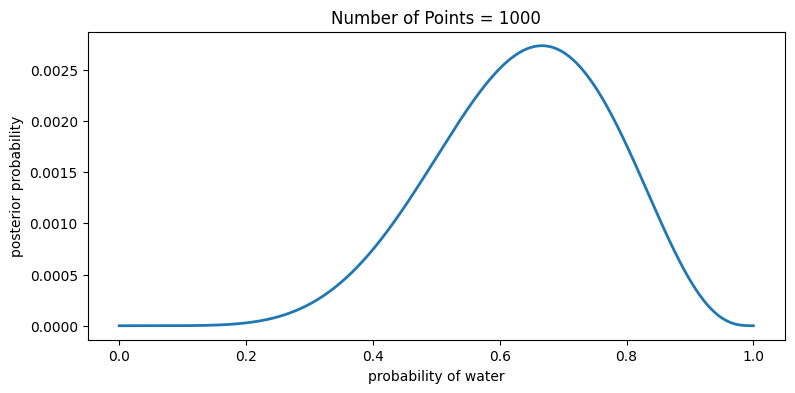

In [3]:
# Plotting
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(p_grid, posterior, "-", linewidth=2.0, markersize = 3)
ax.set(xlabel="probability of water", ylabel="posterior probability", title="Number of Points = "+str(n_points));

# **Sampling**

0.13513513
972


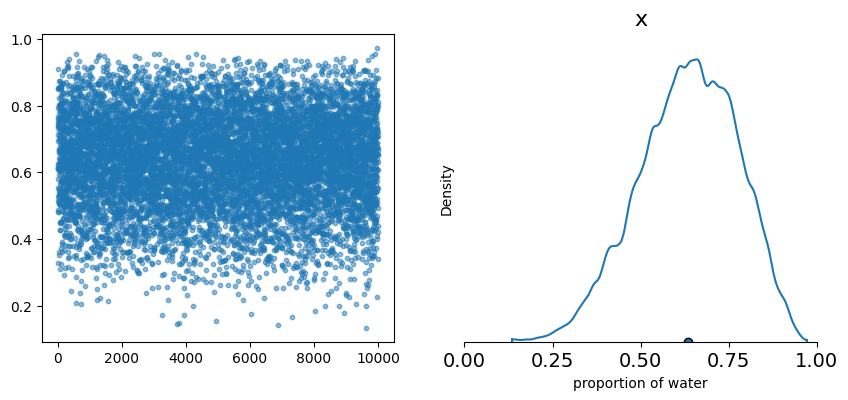

In [4]:
# Sampling
samples_index = tfd.Categorical(probs=posterior).sample(10000)
samples = p_grid.numpy()[samples_index]
print(p_grid.numpy()[tf.reduce_min(samples_index)])
print(tf.reduce_max(samples_index).numpy())
fig, ax = plt.subplots(1,2, figsize=(10, 4))
ax[0].scatter(range(len(samples)),samples, s = 10, alpha = 0.5)
az.plot_density(samples, hdi_prob = 1, ax = ax[1])
ax[1].set(xlabel="proportion of water", ylabel="Density")
ax[1].set_xticks([0,0.25,0.5,0.75,1])
ax[1].axis([0, 1, 0,3])
plt.show()

In [5]:
# Posterior probability that the proportion of water is less than 0.5
print(tf.reduce_sum(posterior[p_grid<0.5]).numpy())
print(np.sum(samples<0.5)/1e4)
print(np.sum((samples>0.5) & (samples<0.75))/1e4)
print(np.percentile(samples, 80)) # 80% percentile
print(np.percentile(samples, [10, 90])) # Percentile Interval (PI)

0.17187461
0.1732
0.6062
0.7587587237358093
[0.44644645 0.81281281]


## **Skewed posterior** and HPDI

[0.8388388 1.       ]


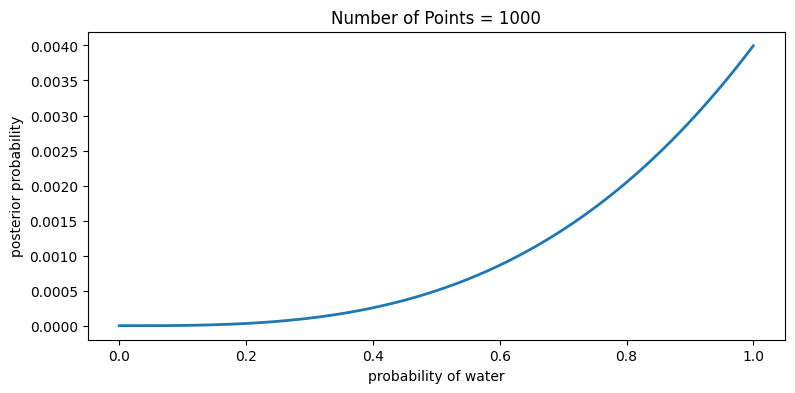

In [6]:
n_points = 1000  # change to an odd number for Code 2.5 graphs to
p_grid = tf.linspace(start=0.0, stop=1.0, num=n_points)

# define prior
prior = tf.ones([n_points])

# compute likelihood at each value in grid
likelihood = tfd.Binomial(total_count=3, probs=p_grid).prob(3)  #6 water out of 9 tosses.

# compute product of likelihood and prior
unstd_posterior = likelihood*prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / tf.reduce_sum(unstd_posterior)
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(p_grid, posterior, "-", linewidth=2.0, markersize = 3)
ax.set(xlabel="probability of water", ylabel="posterior probability", title="Number of Points = "+str(n_points))
# Sampling
samples = p_grid.numpy()[tfd.Categorical(probs=posterior).sample(1e4)]

print(az.hdi(samples, hdi_prob=0.5))  # HPDI

**Loss Function**

In [7]:
loss = list(map(lambda d: tf.reduce_sum(posterior * np.abs(d - p_grid)), p_grid))
tf.print(p_grid[tf.math.argmin(loss)])

0.840840816


# **Simulate Prediction**

In [8]:
# Probability of water = 0, 1, or 2, in 2 tosses
tf.print(list(map(lambda W: tfd.Binomial(total_count=2, probs=0.7).prob(W), np.array([0,1,2]))))

[0.0899999961, 0.420000017, 0.48999998]


In [9]:
# 1 sample from probability of W in 2 tosses (Assuming the proportion of water is 0.7)
tf.print(tfd.Binomial(total_count=2, probs=0.7).sample())
# 10 sample from probability of W in 2 tosses
tf.print(tfd.Binomial(total_count=2, probs=0.7).sample(10))
dummy_w = tfd.Binomial(total_count=2, probs=0.7).sample(1e5)
W, W_count = np.unique(dummy_w.numpy(), return_counts=True)
print(W,'\n', W_count/1e5)

2
[1 1 0 ... 1 2 1]
[0. 1. 2.] 
 [0.09034 0.42034 0.48932]


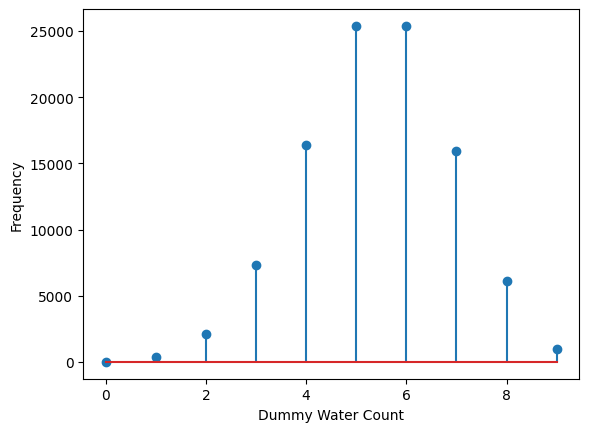

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] 
 [2.0000e-04 3.4400e-03 2.1070e-02 7.3520e-02 1.6414e-01 2.5337e-01
 2.5380e-01 1.5954e-01 6.1000e-02 9.9200e-03]


In [10]:
# Same as above but with 9 tosses
dummy_w = tfd.Binomial(total_count=9, probs=0.6).sample(1e5)
W, W_count = np.unique(dummy_w.numpy(), return_counts=True)
fig, ax = plt.subplots()
ax.stem(W, W_count, use_line_collection = True)
ax.set(xlabel="Dummy Water Count", ylabel="Frequency")
plt.show()
# OR  ax.hist(dummy_w.numpy())
print(W,'\n', W_count/1e5)

### **Posterior Predictive Distribution**

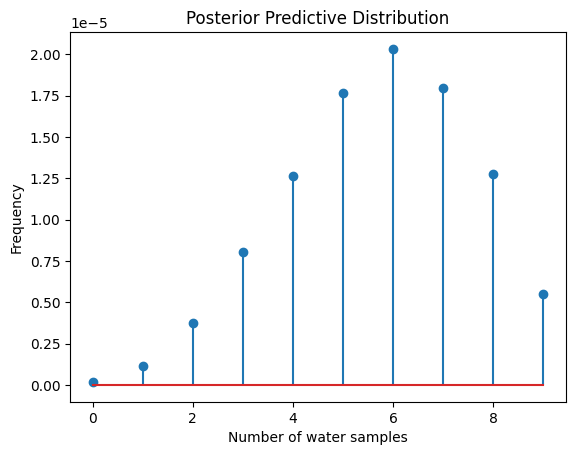

In [11]:
# Calculating Posterior
n_points = 1000  # change to an odd number for Code 2.5 graphs to
p_grid = tf.linspace(start=0.0, stop=1.0, num=n_points)
prior = tf.ones([n_points])
likelihood = tfd.Binomial(total_count=9, probs=p_grid).prob(6)  #6 water out of 9 tosses.
unstd_posterior = likelihood*prior
posterior = unstd_posterior / tf.reduce_sum(unstd_posterior)
posterior_samples = p_grid.numpy()[tfd.Categorical(probs=posterior).sample(1e4)]

# Calculating Posterior Predictive Distribution
dummy_w = tfd.Binomial(total_count=9, probs=posterior_samples).sample()
W, W_count = np.unique(dummy_w.numpy(), return_counts=True)
W_count = W_count/1e8
fig, ax = plt.subplots()
ax.stem(W, W_count, use_line_collection = True)
ax.set(xlabel= "Number of water samples", ylabel="Frequency", title = "Posterior Predictive Distribution")
plt.show()